In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sequentia.preprocessing import *

seed = 1
np.random.seed(seed)
rng = np.random.RandomState(seed)

# Preprocessing

This tutorial notebook describes **some of** the preprocessing methods offered by Sequentia.

---

- [Preprocessing methods](#Preprocessing-methods)
  - [Custom transformations](#Custom-transformations)
  - [Downsampling](#Downsampling)
    - [Mean downsampling](#Mean-downsampling)
    - [Decimation](#Decimation)
  - [Constant trimming](#Constant-trimming)
  - [Centering](#Centering)
  - [Standardizing](#Standardizing)
  - [Filtering](#Filtering)
    - [Median filtering](#Median-filtering)
    - [Mean filtering](#Mean-filtering)
- [Accepted input formats](#Accepted-input-formats)
- [Combining preprocessing methods](#Combining-preprocessing-methods)

## Preprocessing methods

Before we can look at the different preprocessing methods, we have to create a multivariate observation sequence, `F`, that we can use:

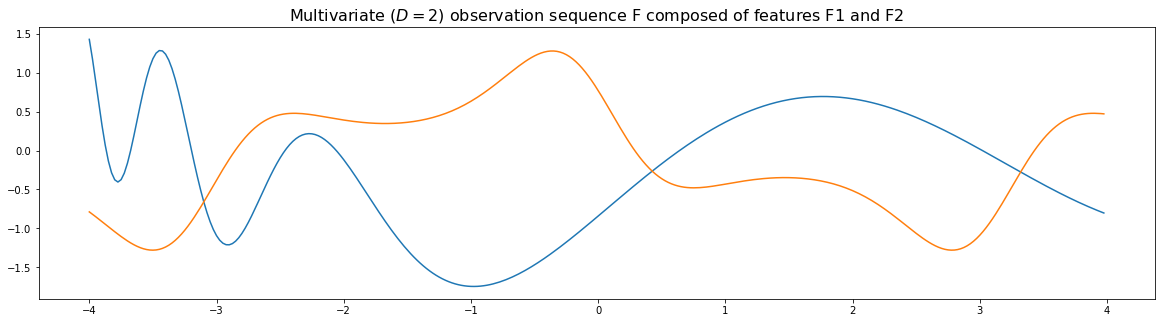

In [2]:
# Specify an input domain for the functions
xs = np.arange(-4., 4., 0.025)

# Create two lambdas that define the features of the observation sequence
f1 = lambda x: (np.sin(x) - np.sin(np.exp(-0.7 * x)))
f2 = lambda x: (np.exp(np.cos(2*x)) * np.cos(x - 5))
# Auxilliary function for downsampling the domain (for plotting)
d = lambda x, n: Downsample(factor=n, method='decimate')(x)

# Compute function values evaluated on the provided domain (xs)
F1, F2 = f1(xs), f2(xs)
# Combine F1 and F2 to form the features for the multivariate sequence F
F = np.vstack((F1, F2)).T

plt.figure(figsize=(20, 5))
plt.title('Multivariate ($D=2$) observation sequence F composed of features F1 and F2', fontsize=16)
plt.plot(xs, F)
plt.show()

### Custom transformations

_Applies a custom transformation to the input observation sequence(s)._

---

The `Custom` class provides a very simple way for the user to specify an arbitrary transformation for a single observation sequence (in the form of a lambda or function).

For example, suppose we wish to only keep the absolute values of the signal observations (which is sometimes done in audio processing). We can define a custom transformation that applies the absolute value function to each observation sequence.

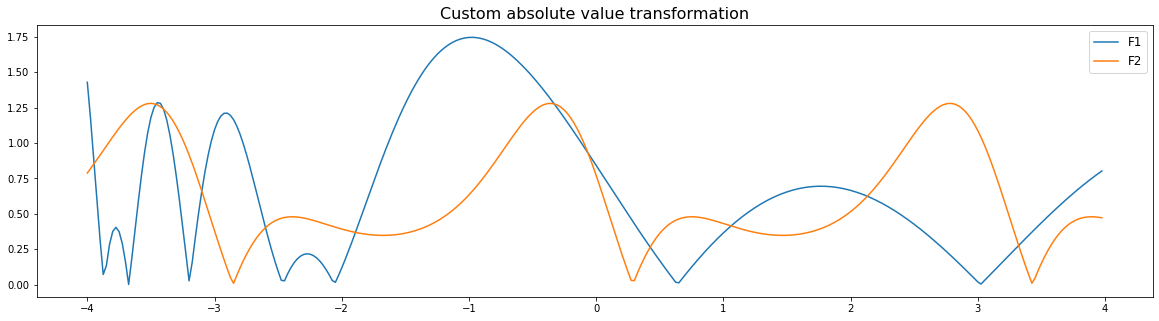

In [3]:
absolute = Custom(lambda x: np.abs(x), name='Absolute', desc='Absolute value function')

plt.figure(figsize=(20, 5))
plt.title('Custom absolute value transformation', fontsize=16)
plt.plot(xs, absolute(F1), 'C0', label='F1')
plt.plot(xs, absolute(F2), 'C1', label='F2')
plt.legend(fontsize=12)
plt.show()

**Note**: Although the `name` and `desc` arguments are optional, they are used to show a description of the transformation when used with [`Compose`](#Combining-preprocessing-methods).

### Downsampling

_Reduces the number of frames in an observation sequence according to a specified downsample factor and one of two methods: **averaging** (mean) and **decimation**._

---

As an example, using a downsample factor of $n=5$ (and the decimation method – which is the default), we can significantly reduce the number of frames in the observation sequence:

In [4]:
print('Original shape: {}'.format(F.shape))
print('Downsampled shape (n=5): {}'.format(Downsample(factor=5)(F).shape))

Original shape: (320, 2)
Downsampled shape (n=5): (64, 2)


#### Mean downsampling

_With a downsample factor of $n$, mean downsampling replaces every group of $n$ consequent observations with a new observation given by mean of those observations – reducing the number of frames by approximately $\frac{1}{n}$._

---

The following plots allow us to see the effects of different downsample factors on the `mean` downsampling method:

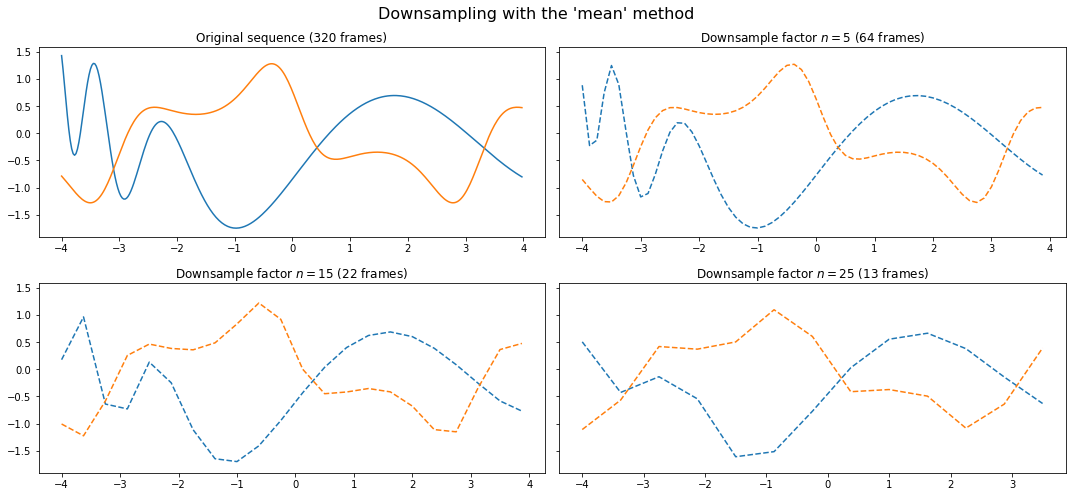

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Downsampling with the 'mean' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(xs, F)

down = Downsample(factor=5, method='mean')(F)
axs[0, 1].set_title('Downsample factor $n=5$ ({} frames)'.format(len(down)))
axs[0, 1].plot(d(xs, n=5), down, '--')

down = Downsample(factor=15, method='mean')(F)
axs[1, 0].set_title('Downsample factor $n=15$ ({} frames)'.format(len(down)))
axs[1, 0].plot(d(xs, n=15), down, '--')

down = Downsample(factor=25, method='mean')(F)
axs[1, 1].set_title('Downsample factor $n=25$ ({} frames)'.format(len(down)))
axs[1, 1].plot(d(xs, n=25), down, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Observe that even with just 64 frames, we can still capture most of the important information about the observation sequence – while making the sequence **five times smaller**!

This is often the case with observation sequences that are recorded using very high sample rates.

#### Decimation

_With a downsample factor $n$, decimation keeps every $n^\text{th}$ observation and removes (decimates) the subsequent $n-1$ observations._

---

Once again, we can visualize the effects of the downsample factor by plotting the downsampled sequences.

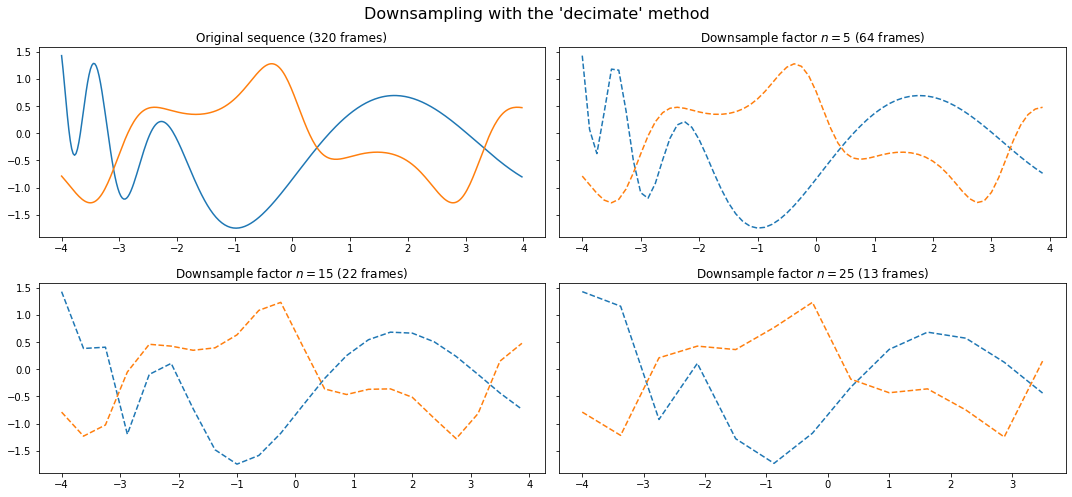

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Downsampling with the 'decimate' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(xs, F)

down = Downsample(factor=5, method='decimate')(F)
axs[0, 1].set_title('Downsample factor $n=5$ ({} frames)'.format(len(down)))
axs[0, 1].plot(d(xs, n=5), down, '--')

down = Downsample(factor=15, method='decimate')(F)
axs[1, 0].set_title('Downsample factor $n=15$ ({} frames)'.format(len(down)))
axs[1, 0].plot(d(xs, n=15), down, '--')

down = Downsample(factor=25, method='decimate')(F)
axs[1, 1].set_title('Downsample factor $n=25$ ({} frames)'.format(len(down)))
axs[1, 1].plot(d(xs, n=25), down, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

From these plots, the differences between downsampling through decimation and averaging aren't immediately obvious.

---

Lets look at a comparison of the two methods using a downsample factor of $n=15$:

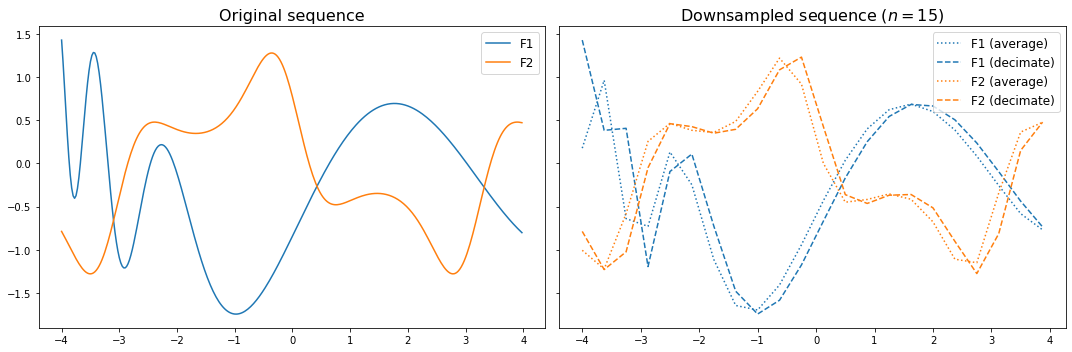

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axs[0].set_title('Original sequence', fontsize=16)
axs[0].plot(xs, F1, label='F1')
axs[0].plot(xs, F2, label='F2')
axs[0].legend(fontsize=12)

axs[1].set_title('Downsampled sequence ($n=15$)', fontsize=16)
axs[1].plot(d(xs, n=15), Downsample(factor=15, method='mean')(F1), 'C0:', label='F1 (average)')
axs[1].plot(d(xs, n=15), Downsample(factor=15, method='decimate')(F1), 'C0--', label='F1 (decimate)')
axs[1].plot(d(xs, n=15), Downsample(factor=15, method='mean')(F2), 'C1:', label='F2 (average)')
axs[1].plot(d(xs, n=15), Downsample(factor=15, method='decimate')(F2), 'C1--', label='F2 (decimate)')
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

Once again, it might not be straightforward to choose between the two methods. The best approach would probably be to choose the method that minimizes validation error.

### Constant trimming

_Removes constant observations from an observation sequence._

_Many datasets consisting of sequential data often pad observation sequences with zeros or other values in order to ensure that the machine learning algorithms receive sequences of equal length. Although this comes with the advantage of being able to represent the sequences in a matrix, the added zeros may affect the performance of the machine learning algorithms._

_As the algorithms implemented by Sequentia focus on supporting variable-length sequences out of the box, padding is not necessary, and can be removed with this method._

_**Note**: This preprocessing method does not only remove trailing constant observations from the start or end of a sequence, but will also remove **any** constant observations that occur anywhere in the sequence._

---

It is clear from the description what constant trimming does, but lets look at an example:

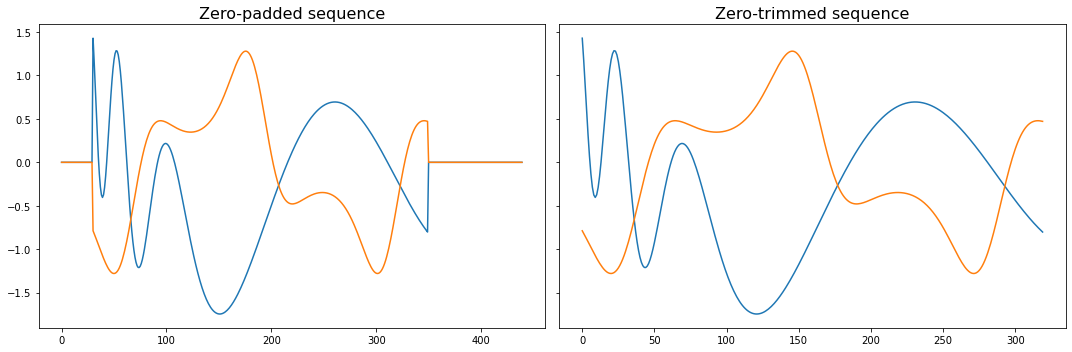

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

zeros = np.zeros((30, 2))
padded_F = np.vstack((zeros, F, zeros, zeros, zeros))

axs[0].set_title('Zero-padded sequence', fontsize=16)
axs[0].plot(padded_F)

axs[1].set_title('Zero-trimmed sequence', fontsize=16)
axs[1].plot(TrimConstants(constant=0)(padded_F))

plt.tight_layout()
plt.show()

### Centering

*Centers an observation sequence by either*:

- _(default) centering each feature or dimension **independently** for each observation, so that they all have zero mean,_
- _centering each feature or dimension **collectively** (using a single mean for all observation sequences)_.

---

As a simple check on `F`:

In [9]:
np.mean(Center()(F), axis=0)

array([-6.66133815e-17, -4.44089210e-17])

To see the effects of centering, we can simply plot the centered observation sequence:

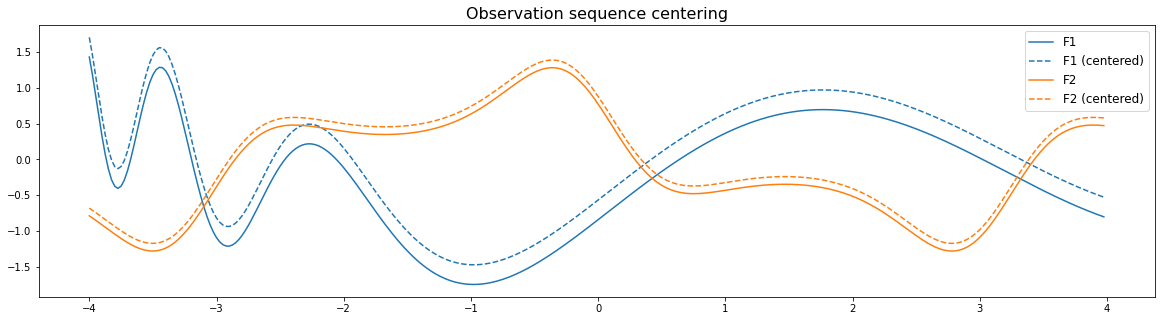

In [10]:
plt.figure(figsize=(20, 5))
plt.title('Observation sequence centering', fontsize=16)
plt.plot(xs, F1, label='F1')
plt.plot(xs, Center()(F1), 'C0--', label='F1 (centered)')
plt.plot(xs, F2, label='F2')
plt.plot(xs, Center()(F2), 'C1--', label='F2 (centered)')
plt.legend(fontsize=12)
plt.show()

### Standardizing

*Standardizes an observation sequence by either*:

- _(default) transforming each feature or dimension **individually** for each observation sequence so that they each have zero mean and unit variance,_
- _transforming each feature or dimension **collectively** (using a single mean and standard deviation)._

---

As a simple check on `F`:

In [11]:
print('Mean: {}'.format(Standardize()(F).mean(axis=0)))
print('Deviation: {}'.format(Standardize()(F).std(axis=0)))

Mean: [ 0.00000000e+00 -2.22044605e-17]
Deviation: [1. 1.]


To see the effects of standardizing, we can simply plot the standardized observation sequence:

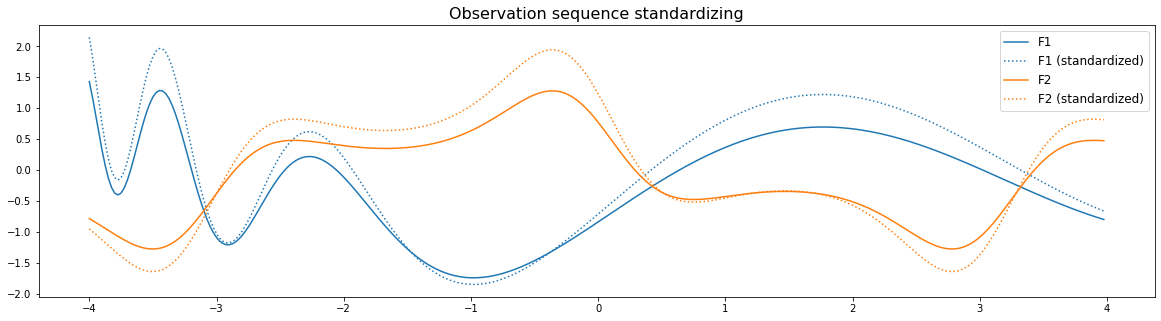

In [12]:
plt.figure(figsize=(20, 5))
plt.title('Observation sequence standardizing', fontsize=16)
plt.plot(xs, F1, label='F1')
plt.plot(xs, Standardize()(F1), 'C0:', label='F1 (standardized)')
plt.plot(xs, F2, label='F2')
plt.plot(xs, Standardize()(F2), 'C1:', label='F2 (standardized)')
plt.legend(fontsize=12)
plt.show()

### Filtering

_Removes some unwanted components (such as noise) from an observation sequence according to some window size and one of two methods: **median** and **mean** filtering._

---

To demonstrate and visualize filtering methods, we need to add some noise to the original observation sequence.

In [13]:
# Add noise to the original observation sequence
noise = 0.2 * rng.normal(0, 1, F.shape)
F_noisy = F + noise

#### Median filtering

*With a window size of $n$, median filtering replaces every observation $\mathbf{o}^{(t)}$ with the median of the window of observations of size $n$ containing $\mathbf{o}^{(t)}$ in its centre:* 

$$\mathbf{o}^{(t)\prime}=\mathrm{med}\underbrace{\left[\ldots, \mathbf{o}^{(t-1)}, \mathbf{o}^{(t)}, \mathbf{o}^{(t+1)}, \ldots\right]}_n$$

---

The following plots allow us to see the effects of different window sizes on the `median` downsampling method:

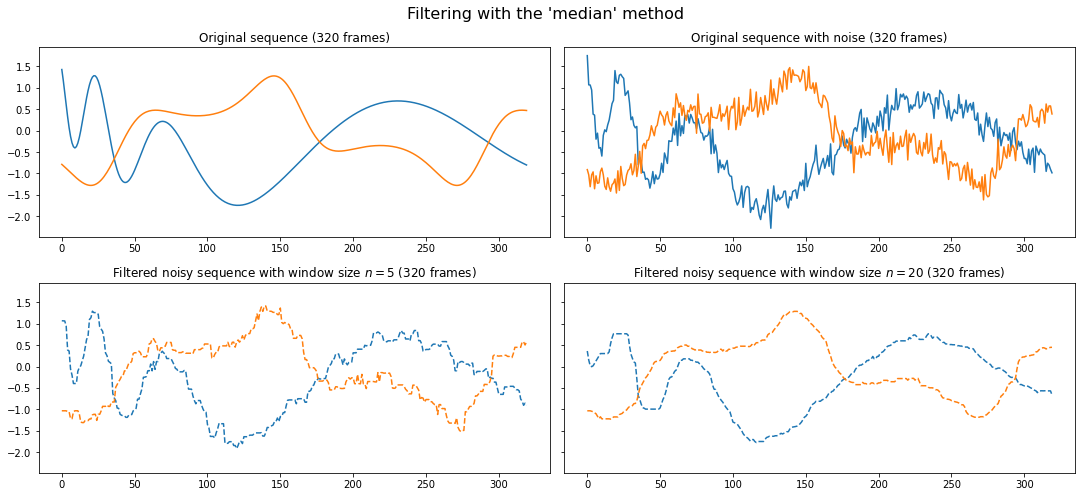

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Filtering with the 'median' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(F)

axs[0, 1].set_title('Original sequence with noise ({} frames)'.format(len(F_noisy)))
axs[0, 1].plot(F_noisy)

filtered = Filter(window_size=5, method='median')(F_noisy)
axs[1, 0].set_title('Filtered noisy sequence with window size $n=5$ ({} frames)'.format(len(filtered)))
axs[1, 0].plot(filtered, '--')

filtered = Filter(window_size=20, method='median')(F_noisy)
axs[1, 1].set_title('Filtered noisy sequence with window size $n=20$ ({} frames)'.format(len(filtered)))
axs[1, 1].plot(filtered, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The median filter does a good job at reducing the noise! With generally a smoother function as the window size increases.

#### Mean filtering

*With a window size of $n$, mean filtering replaces every observation $\mathbf{o}^{(t)}$ with the mean of the window of observations of size $n$ containing $\mathbf{o}^{(t)}$ in its centre:* 

$$\mathbf{o}^{(t)\prime}=\mathrm{mean}\underbrace{\left[\ldots, \mathbf{o}^{(t-1)}, \mathbf{o}^{(t)}, \mathbf{o}^{(t+1)}, \ldots\right]}_n$$

---

The following plots allow us to see the effects of different window sizes on the `mean` downsampling method:

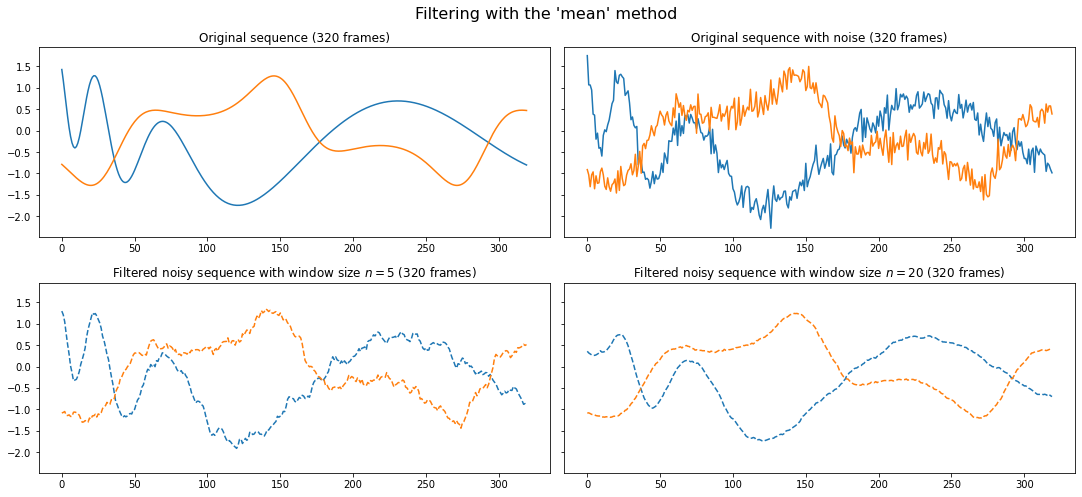

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Filtering with the 'mean' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(F)

axs[0, 1].set_title('Original sequence with noise ({} frames)'.format(len(F_noisy)))
axs[0, 1].plot(F_noisy)

filtered = Filter(window_size=5, method='mean')(F_noisy)
axs[1, 0].set_title('Filtered noisy sequence with window size $n=5$ ({} frames)'.format(len(filtered)))
axs[1, 0].plot(filtered, '--')

filtered = Filter(window_size=20, method='mean')(F_noisy)
axs[1, 1].set_title('Filtered noisy sequence with window size $n=20$ ({} frames)'.format(len(filtered)))
axs[1, 1].plot(filtered, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Similarly to the downsampling methods, it often isn't clear which of the filtering methods will perform best.

## Accepted input formats

Just as with the `fit()` and `predict()` functions on the Sequentia classifiers, each of the preprocessing functions accepts:

- `numpy.ndarray`: A single multivariate observation sequence
- `list(numpy.ndarray)`: Multiple multivariate observation sequences

**Note**: The observation sequences must strictly have a second dimension. If using one-dimensional observation sequences, these must be reshaped from `(T,)` to `(T, 1)`, where `T` is the number of frames.

---

Nothing changes about how you call the preprocessing functions:

In [16]:
# Single multivariate observation sequences
down = Downsample(factor=5, method='mean')(F)
down.shape

(64, 2)

In [17]:
# Multiple multivariate observation sequences
Fs = [F]*5
down = Downsample(factor=5, method='mean')(Fs)
[f.shape for f in down]

[(64, 2), (64, 2), (64, 2), (64, 2), (64, 2)]

## Combining preprocessing methods

The `Compose` class can be used to chain preprocessing method calls:

In [18]:
transforms = Compose([
    TrimConstants(),
    Center(),
    Standardize(),
    Custom(lambda x: np.abs(x), name='Absolute', desc='Absolute value function'),
    Filter(window_size=10, method='median'),
    Downsample(factor=15, method='decimate')
])

# Summarize the preprocessing steps
transforms.summary()

                   Preprocessing summary:                   
1. TrimConstants
   Remove constant observations (=0.0)
------------------------------------------------------------
2. Center
   Centering around mean (zero mean) (independent)
------------------------------------------------------------
3. Standardize
   Standard scaling (zero mean, unit variance) (independent)
------------------------------------------------------------
4. Custom (Absolute)
   Absolute value function
------------------------------------------------------------
5. Filter
   Median filtering with window-size 10
------------------------------------------------------------
6. Downsample
   Decimation downsampling with factor 15


In [19]:
F_pre = transforms(Fs)